In [ ]:
## This is code to run the Spatial inference of RNA velocity at the single-cell resolution (SIRV) by Abdelaal et al 2024: https://github.com/tabdelaal/SIRV/blob/main/README.md.
## The background code needs to be changed to ensure it works on Visium data. 

In [1]:
#Load in packages needed

import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.insert(1,'SIRV/')
from main import SIRV

import h5py
import anndata as ad
import scipy
import scipy.stats as st
import squidpy as sq
import seaborn as sns

In [3]:
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.7.3 pandas==1.4.3 scikit-learn==1.1.2 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


In [3]:
#needed to !pip install louvain to get scv.tl.velocity_clusters(merged) to work
#!pip install louvain

  Using cached louvain-0.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


In [ ]:
# Need to download the .py notebooks from github. Change tab to raw before downloading
!wget https://raw.githubusercontent.com/tabdelaal/SIRV/main/SIRV/dimensionality_reduction.py
!wget https://raw.githubusercontent.com/tabdelaal/SIRV/main/SIRV/main.py
!wget https://raw.githubusercontent.com/tabdelaal/SIRV/main/SIRV/principal_vectors.py

In [ ]:
#scv.set_figure_params(facecolor="white")
#sc.settings.verbosity = 3

### Load in the scRNA sample

#### Process until merge point

In [ ]:
# If need to convert loom to h5ad file
#filename = '.path_to_file/X.loom'
#RNA = scv.read(filename, cache=True)
#RNA.write('.path_to_file/X.h5ad')

In [ ]:
#Otherwise can just import loom directly
#load your own scRNAseq dataset
RNA = sc.read_loom('path_to_file/X.loom')

In [6]:
type(RNA.layers['unspliced'])

scipy.sparse.csr.csr_matrix

In [4]:
#check what format the spliced layers are in (if in one column then a csr matrix and need to .toarray() in the merge code below (in main.py)).
pd.DataFrame(RNA.layers['spliced'])

0
0       (0, 39)\t1\n  (0, 42)\t1\n  (0, 45)\t1\n  (0...
1       (0, 42)\t1\n  (0, 51)\t1\n  (0, 53)\t1\n  (0...
2       (0, 148)\t1\n  (0, 250)\t1\n  (0, 411)\t1\n ...
3       (0, 59)\t2\n  (0, 132)\t1\n  (0, 146)\t1\n  ...
4       (0, 53)\t1\n  (0, 60)\t2\n  (0, 121)\t1\n  (...
...                                                 ...
4898    (0, 39)\t2\n  (0, 55)\t1\n  (0, 58)\t1\n  (0...
4899    (0, 80)\t1\n  (0, 366)\t1\n  (0, 716)\t1\n  ...
4900    (0, 50)\t1\n  (0, 55)\t1\n  (0, 60)\t1\n  (0...
4901    (0, 50)\t1\n  (0, 57)\t1\n  (0, 59)\t1\n  (0...
4902    (0, 60)\t1\n  (0, 61)\t1\n  (0, 121)\t2\n  (...

[4903 rows x 1 columns]

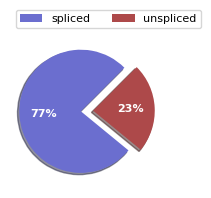

In [5]:
#proportions
scv.pl.proportions(RNA)

In [6]:
#Processing the data
# remove doublets
sc.external.pp.scrublet(RNA)

Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.2%


In [7]:
# do some filtering and normalisation if not done already in previous workflow
scv.pp.filter_and_normalize(RNA, n_top_genes=5000)#, min_shared_counts=10)
scv.pp.pca(RNA)

Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
Logarithmized X.


### Load in stRNA sample

In [ ]:
#load Visium sample:can import directly if don't have h5ad file.Not preprocessed
spatial = sc.read_visium('path_to_sample/outs')

In [4]:
spatial.var_names_make_unique()
spatial.var["mt"] = spatial.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(spatial, qc_vars=["mt"], inplace=True)

In [14]:
spatial.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAGAGCGACTCCT-1          1         14         94               2353   
AAACAGCTTTCAGAAG-1          1         43          9               1523   
AAACCGGGTAGGTACC-1          1         42         28               1811   
AAACCTCATGAAGTTG-1          1         37         19               1041   
AAACGAGACGGTTGAT-1          1         35         79               1186   
...                       ...        ...        ...                ...   
TTGTGAGGCATGACGC-1          1         43         13               1898   
TTGTGGCCCTGACAGT-1          1         18         60               2141   
TTGTGGTAGGAGGGAT-1          1         50         28               1370   
TTGTTTCACATCCAGG-1          1         58         42               1456   
TTGTTTCATTAGTCTA-1          1         60         30               1810   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAGAGCGACTCCT-1                 7.763871        6867.0            8.834628   
AAACAGCTTTCAGAAG-1                 7.329094        4071.0            8.311890   
AAACCGGGTAGGTACC-1                 7.502186        3549.0            8.174703   
AAACCTCATGAAGTTG-1                 6.948897        1823.0            7.508787   
AAACGAGACGGTTGAT-1                 7.079184        2389.0            7.779048   
...                                     ...           ...                 ...   
TTGTGAGGCATGACGC-1                 7.549083        3525.0            8.167919   
TTGTGGCCCTGACAGT-1                 7.669495        7473.0            8.919186   
TTGTGGTAGGAGGGAT-1                 7.223296        3102.0            8.040125   
TTGTTTCACATCCAGG-1                 7.284135        2757.0            7.922261   
TTGTTTCATTAGTCTA-1                 7.501634        5000.0            8.517393   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAGAGCGACTCCT-1                   46.861803                    52.264453   
AAACAGCTTTCAGAAG-1                   51.117662                    56.595431   
AAACCGGGTAGGTACC-1                   34.544942                    40.631164   
AAACCTCATGAAGTTG-1                   37.191443                    43.335162   
AAACGAGACGGTTGAT-1                   41.607367                    48.137296   
...                                        ...                          ...   
TTGTGAGGCATGACGC-1                   30.780142                    36.765957   
TTGTGGCCCTGACAGT-1                   54.328917                    59.306838   
TTGTGGTAGGAGGGAT-1                   44.777563                    50.644745   
TTGTTTCACATCCAGG-1                   36.416395                    42.364889   
TTGTTTCATTAGTCTA-1                   49.380000                    54.800000   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAGAGCGACTCCT-1                    58.977720                    69.739333   
AAACAGCTTTCAGAAG-1                    62.834684                    74.871039   
AAACCGGGTAGGTACC-1                    48.408002                    63.060017   
AAACCTCATGAAGTTG-1                    53.867252                    70.323642   
AAACGAGACGGTTGAT-1                    56.509000                    71.285057   
...                                         ...                          ...   
TTGTGAGGCATGACGC-1                    44.312057                    60.340426   
TTGTGGCCCTGACAGT-1                    65.462331                    75.444935   
TTGTGGTAGGAGGGAT-1                    58.317215                    71.953578   
TTGTTTCACATCCAGG-1                    50.090678                    65.324628   
TTGTTTCATTAGTCTA-1                    61.380000                    73.740000   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  
AAACAGAGCGACTCCT-1              0.0                    0.0            0.0  
AAACAGCTTTCAGAAG-1              0.0                    0.0            0.0  
AAACCGGGTAGGTACC-1  

<AxesSubplot: xlabel='n_genes_by_counts'>

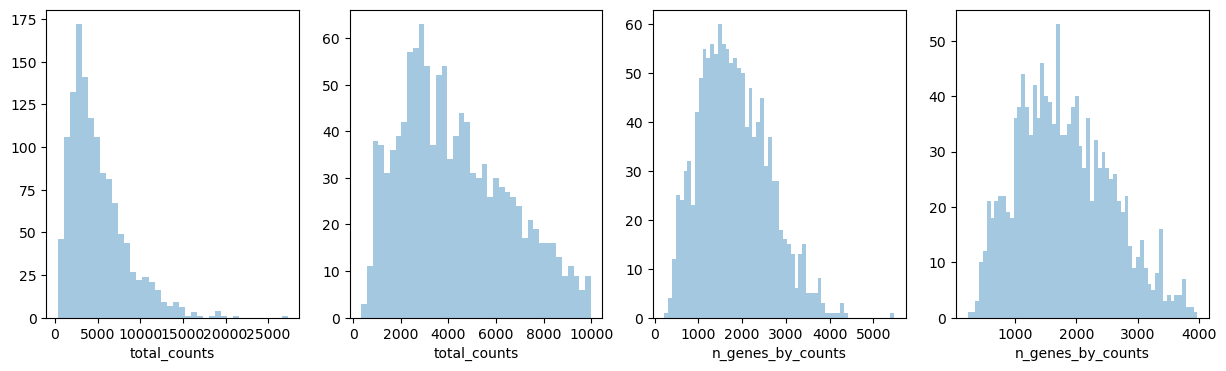

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(spatial.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(spatial.obs["total_counts"][spatial.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(spatial.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(spatial.obs["n_genes_by_counts"][spatial.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [ ]:
#filter the data based on above
sc.pp.filter_cells(spatial, min_counts=1000)
sc.pp.filter_cells(spatial, max_counts=35000)
spatial = spatial[spatial.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {spatial.n_obs}")
sc.pp.filter_genes(spatial, min_counts =10)

#cells after MT filter: 1257


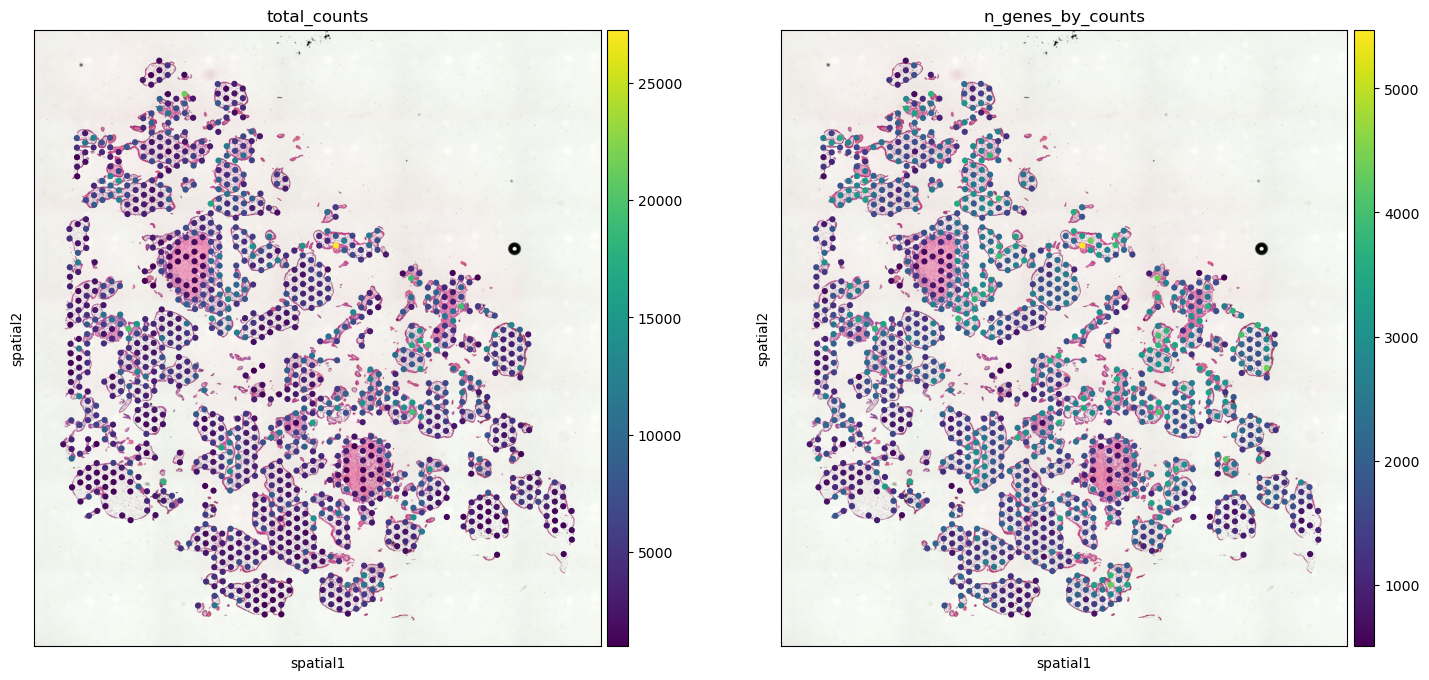

In [7]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(spatial, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [8]:
scv.pp.pca(spatial)

### Merge the scRNA and stRNA datasets

In [13]:
# Apply SIRV to integrate both datasets and predict the un/spliced expressions
merged = SIRV(spatial, RNA, 50)

In [15]:
merged.X = scipy.sparse.csc_matrix(merged.X) 

In [ ]:
#save out merged data
merged.write('path_to_file/merged.h5ad')

In [22]:
merged

AnnData object with n_obs × n_vars = 1257 × 3906
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gene_count_corr', 'mean', 'std'
    uns: 'spatial', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [15]:
print(scv.datasets.AnnData)


<class 'anndata._core.anndata.AnnData'>


In [8]:
# Normalize the imputed un/spliced expressions, this will also re-normalize the full spatial mRNA 'X', this needs to be undone 
scv.pp.normalize_per_cell(merged, enforce=True)

Normalized count data: X, spliced, unspliced.


In [ ]:
# Undo the double normalization of the full mRNA 'X'
merged.X = spatial.to_df()[merged.var_names]


In [18]:
# Zero mean and unit variance scaling, PCA, building neibourhood graph, running
# umap and cluster the  spatial data using Leiden clustering
sc.pp.scale(merged)
sc.tl.pca(merged)
sc.pp.neighbors(merged, n_neighbors=20, n_pcs=30)
sc.tl.umap(merged, min_dist=0.5, random_state = 1)


In [ ]:
# calculate leiden clusters
sc.tl.leiden(merged, resolution=0.9, key_added="leiden")

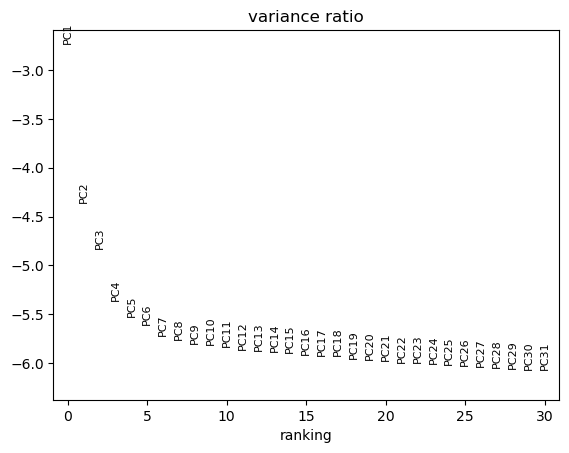

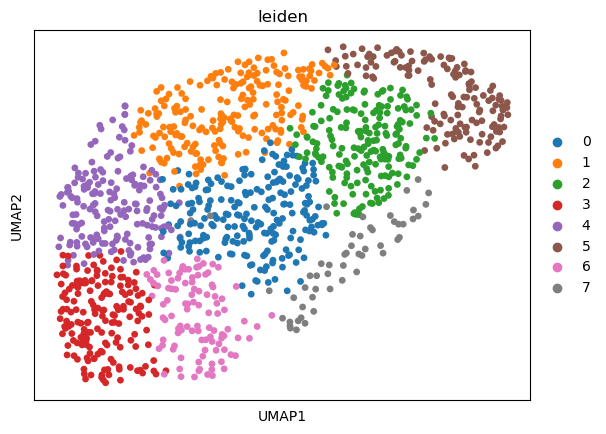

In [23]:
sc.pl.pca_variance_ratio(merged, n_pcs=30, log=True)
sc.pl.umap(merged, color='leiden')

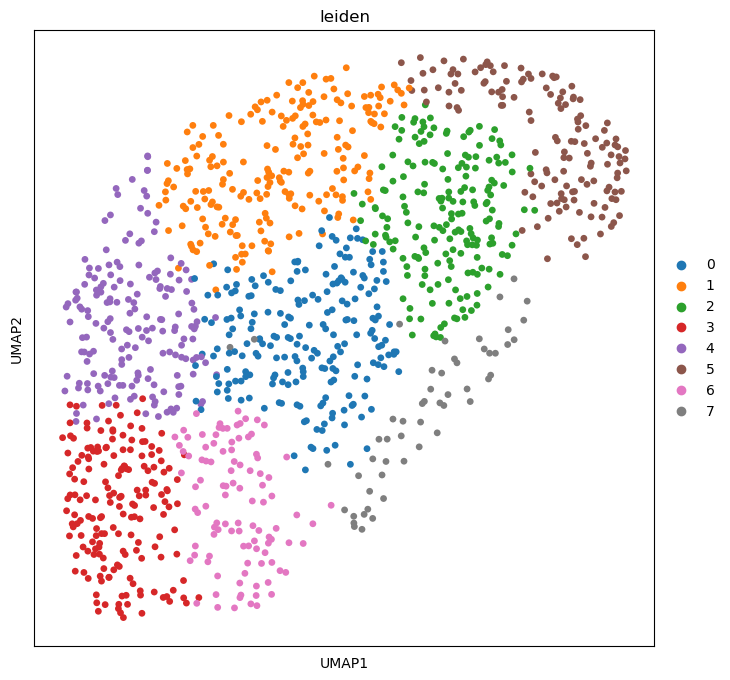

In [26]:
sc.pl.umap(merged, color='leiden')#, save = 'M1727_leiden_clusters.svg')


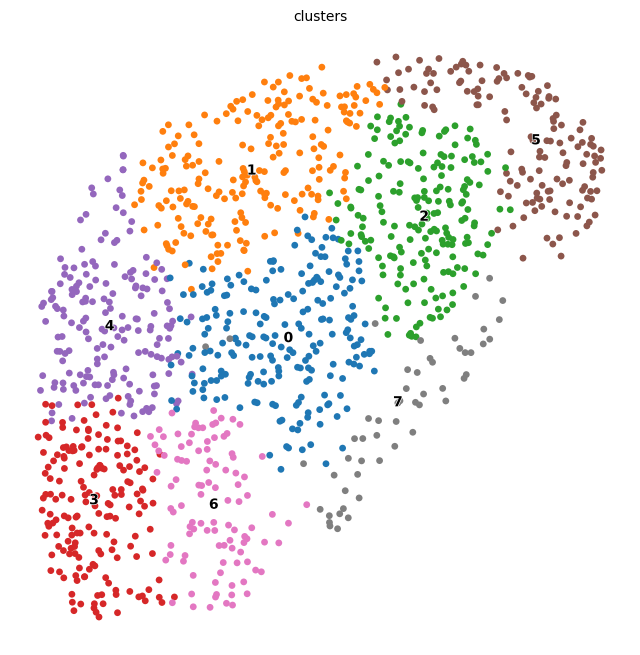

In [ ]:
# add the cluster numbers to the UMAP
scv.pl.scatter(merged, color='clusters')

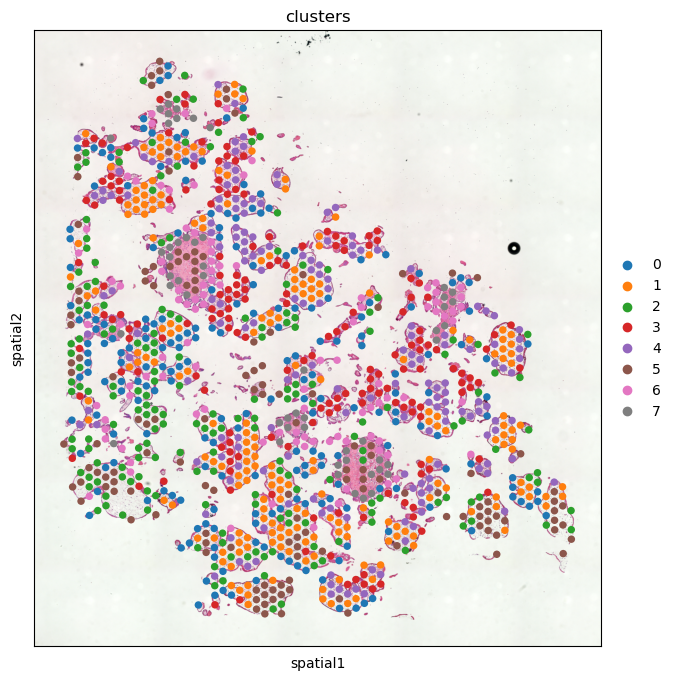

In [ ]:
# plot clusters onto the spatial image
sc.pl.spatial(merged, img_key="hires", color="clusters", size=1.2)#, save = 'M1727_spatial_clusters.svg')

#### Calculate Leiden DEGS for cluster identification

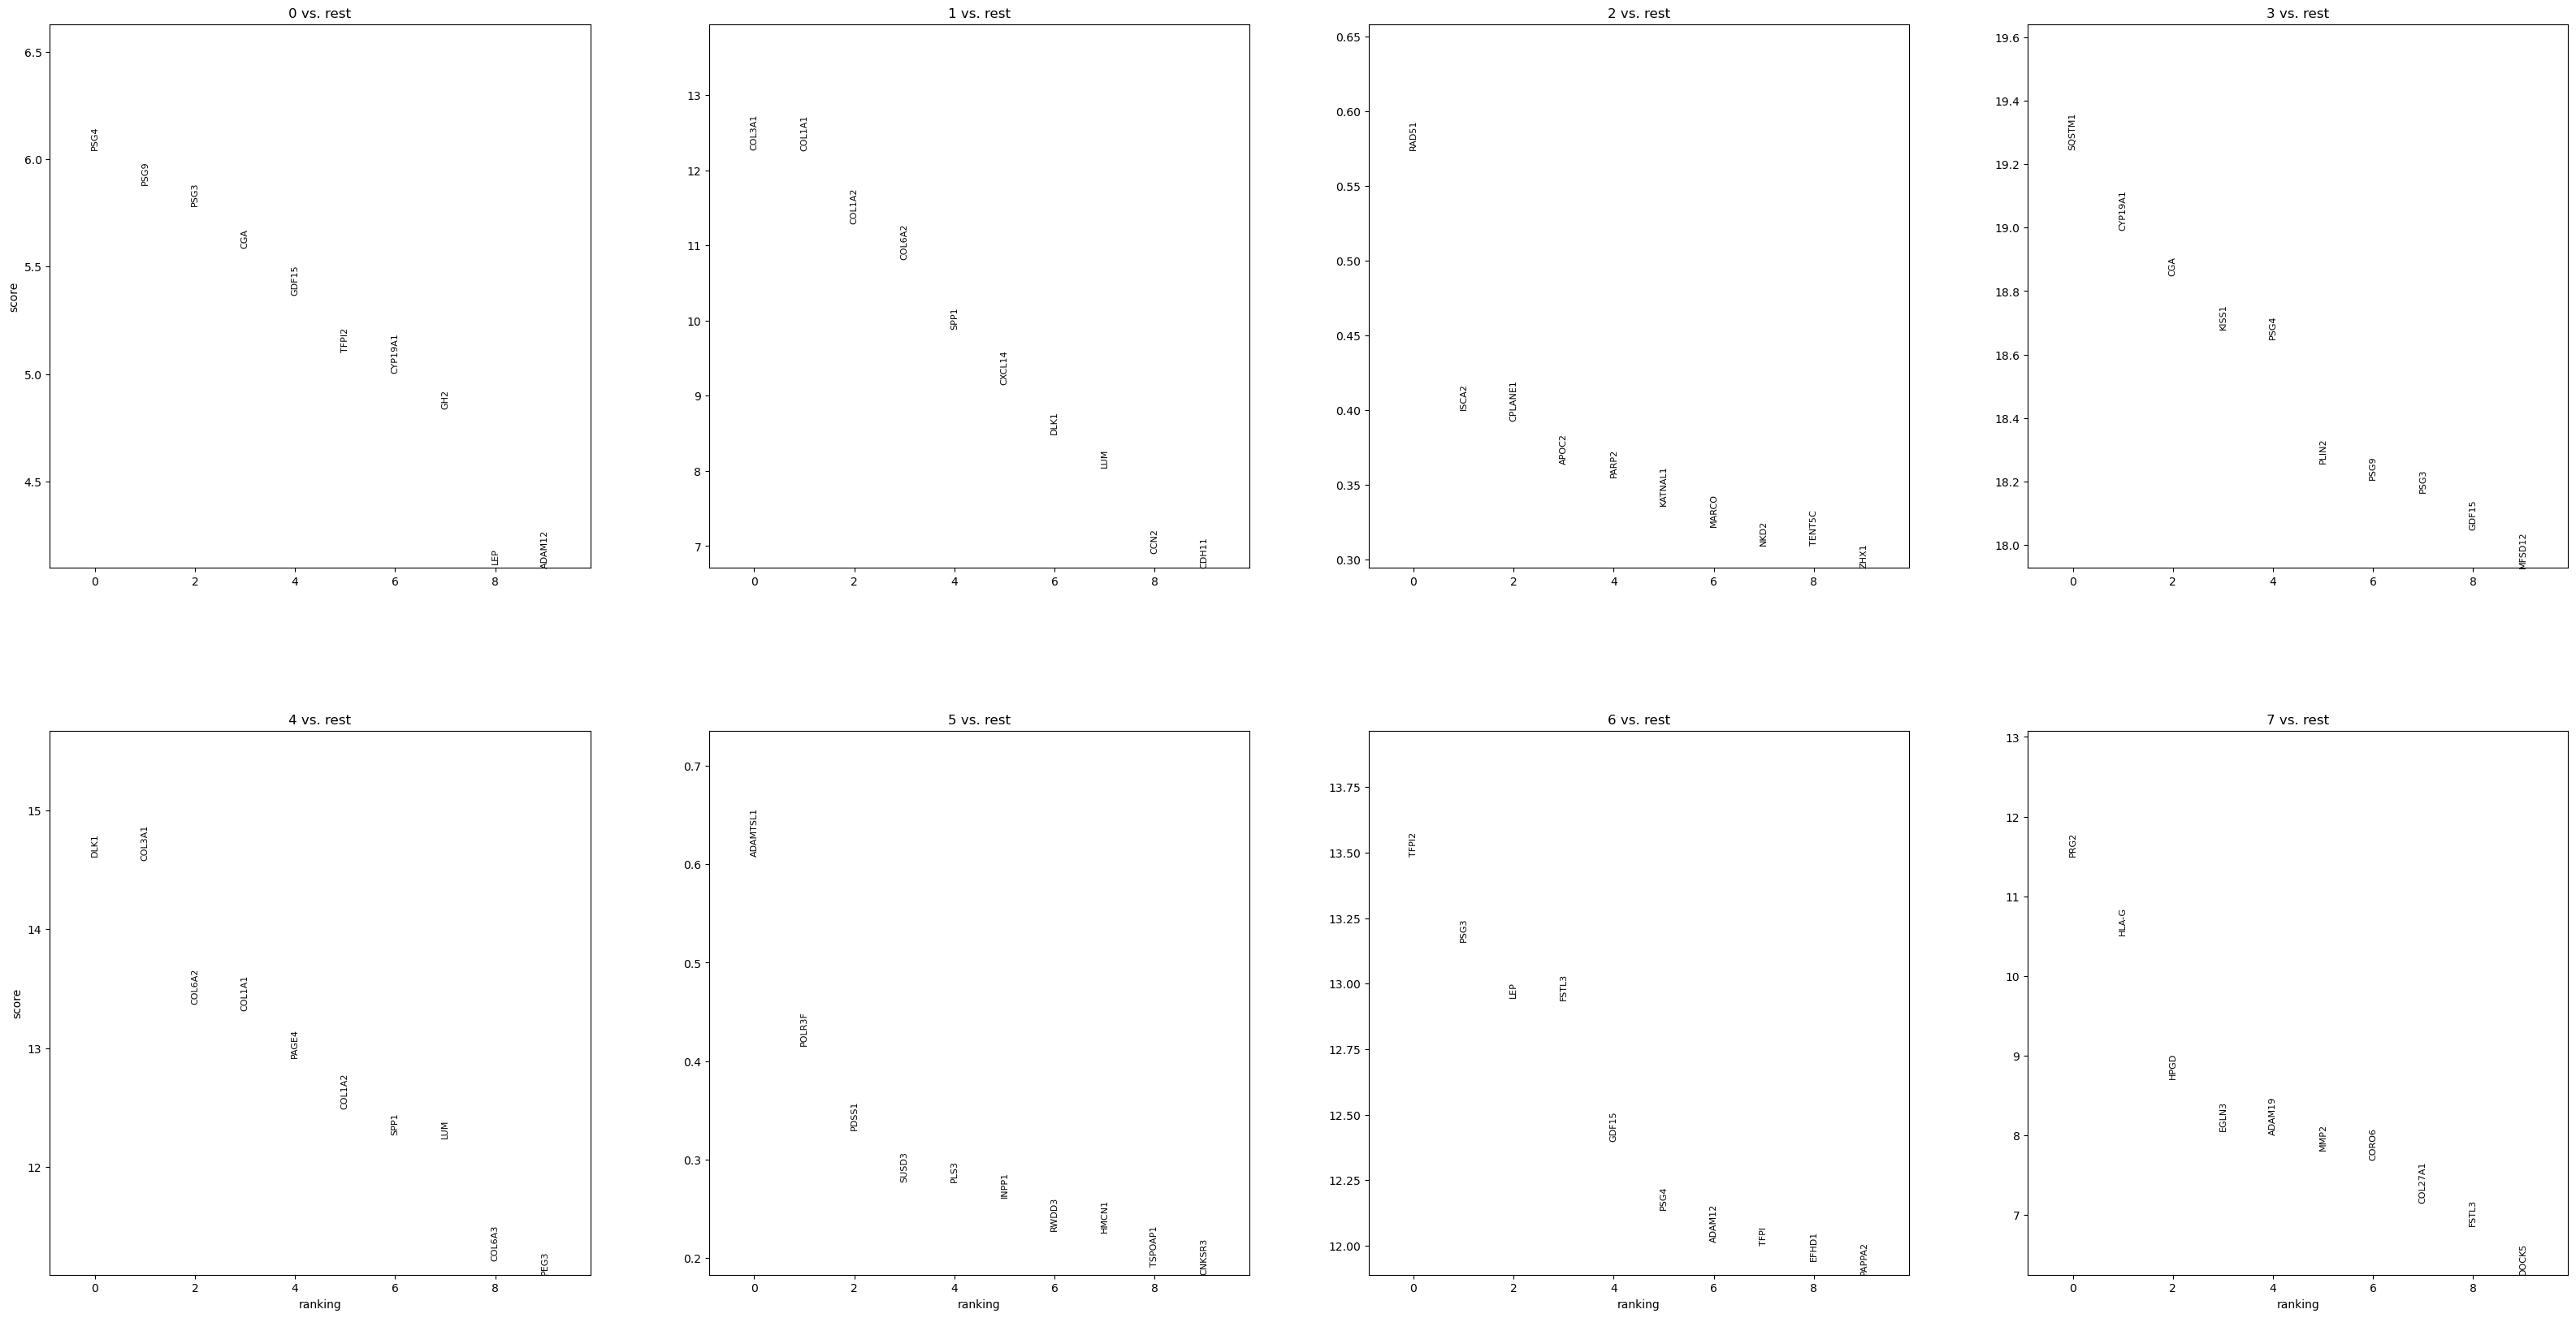

In [ ]:
# calculate DEGS
sc.tl.rank_genes_groups(merged, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(merged, n_genes=10, sharey=False)

In [33]:
pd.DataFrame(merged.uns['rank_genes_groups']['names']).head(10)

0       1        2        3       4         5       6        7
0     PSG4  COL3A1    RAD51   SQSTM1    DLK1  ADAMTSL1   TFPI2     PRG2
1     PSG9  COL1A1    ISCA2  CYP19A1  COL3A1    POLR3F    PSG3    HLA-G
2     PSG3  COL1A2  CPLANE1      CGA  COL6A2     PDSS1     LEP     HPGD
3      CGA  COL6A2    APOC2    KISS1  COL1A1     SUSD3   FSTL3    EGLN3
4    GDF15    SPP1    PARP2     PSG4   PAGE4      PLS3   GDF15   ADAM19
5    TFPI2  CXCL14  KATNAL1    PLIN2  COL1A2     INPP1    PSG4     MMP2
6  CYP19A1    DLK1    MARCO     PSG9    SPP1     RWDD3  ADAM12    CORO6
7      GH2     LUM     NKD2     PSG3     LUM     HMCN1    TFPI  COL27A1
8      LEP    CCN2   TENT5C    GDF15  COL6A3   TSPOAP1   EFHD1    FSTL3
9   ADAM12   CDH11     ZHX1   MFSD12    PEG3    CNKSR3  PAPPA2    DOCK5

In [61]:
#save whichever cdetermined cluster as csv
df = pd.DataFrame(merged.uns['rank_genes_groups']['names'])
df.to_csv('/home/megan/visium_velocity_analysis/M1727_cluster_genes_merged.csv') 

In [99]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'STB1',
     '1': 'FIBRO/HB',
     '2': 'HB/FIBRO/CTB',
     '3': 'STB2',
     '4': 'FIBRO',
     '5': 'ENDO/FIBRO/HB',
     '6': 'STB/EVT',
     '7': 'EVT',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
merged.obs['cell type'] = merged.obs['clusters'].map(cluster2annotation).astype('category')

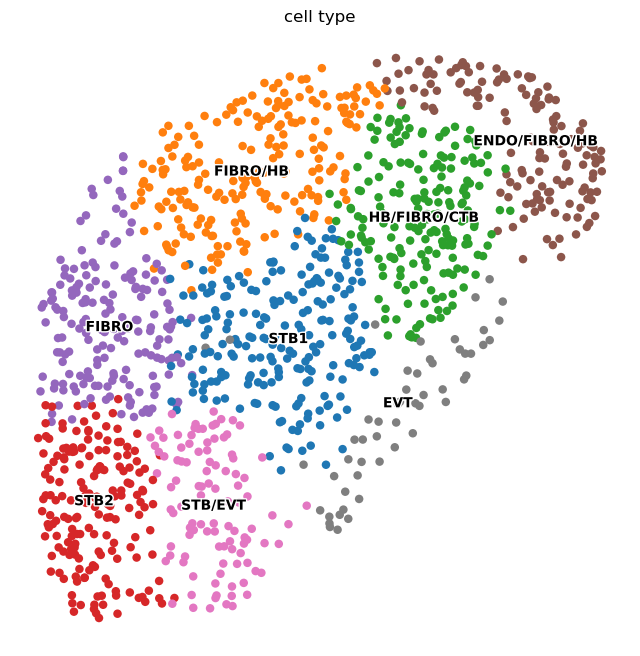

In [ ]:
# plot newly names cluster labels onto UMAP
sc.pl.umap(merged, color='cell type', legend_loc='on data', size=150,
           frameon=False, legend_fontsize=10, legend_fontoutline=2, save='M1727_cluster_labelled_umap.svg')

In [10]:
#load processed h5ad file
merged = sc.read_h5ad('/megan/spaceranger/spatial_data_M1727_merged_incl_velocity.h5ad')

In [11]:
#check the data
merged

AnnData object with n_obs × n_vars = 1257 × 3906
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'gene_count_corr', 'mean', 'std', 'velocity_offset2', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'spatial', 'umap', 'velocity_graph', 'velocity_grap

### Calcuating velocity and pseudotime

In [25]:
# Calculating RNA velocities and projecting them on the UMAP embedding and spatial coordinates of the tissue
scv.pp.moments(merged, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
#calculate velocity
scv.tl.velocity(merged, fit_offset2= True)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [27]:
scv.tl.velocity_graph(merged)

computing velocity graph (using 1/28 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


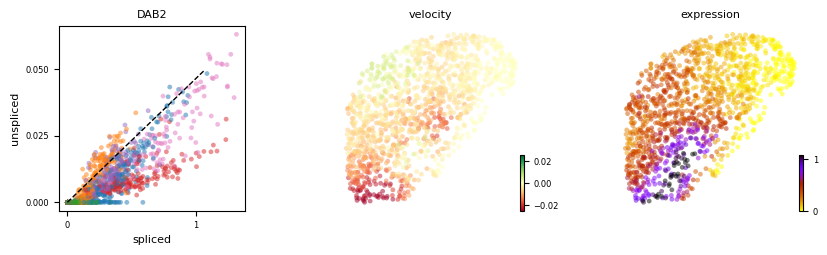

In [26]:
#plots velocity but you need to specify a var --- this is a UMAP
scv.pl.velocity(merged, 'DAB2')

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


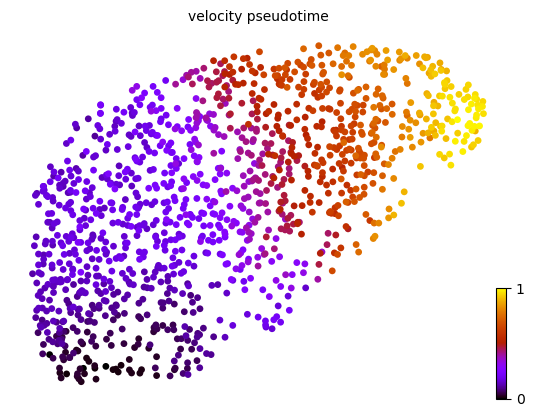

In [ ]:
# calculate and plot velocity_pseudotime onto UMAP
scv.tl.velocity_pseudotime(merged)
scv.pl.scatter(merged, color='velocity_pseudotime', color_map='gnuplot')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


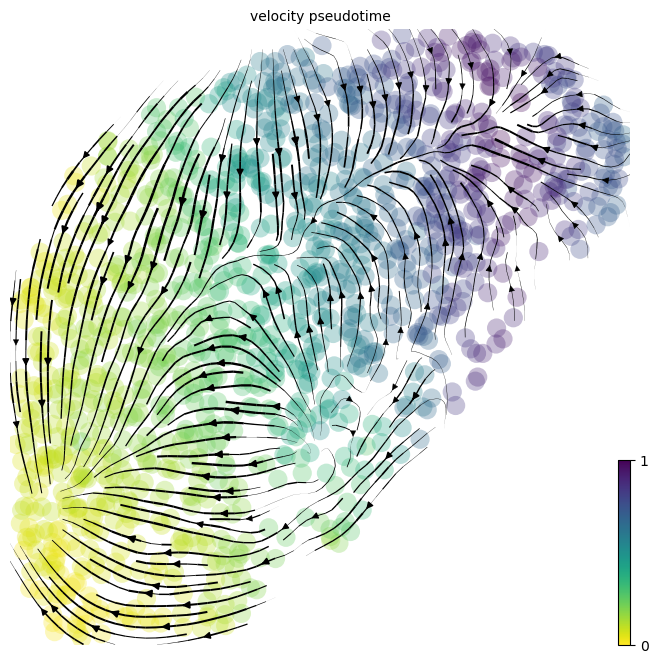

In [ ]:
# plot velocity streams on UMAP
scv.pl.velocity_embedding_stream(merged, color='velocity_pseudotime', basis='umap')#, save = 'umap_velocity_pseudotime.svg')

#### Preprocessing for PAGA

In [ ]:
# need to run for PAGA to work on this data
merged.uns['neighbors']['distances'] = merged.obsp['distances']
merged.uns['neighbors']['connectivities'] = merged.obsp['connectivities']

In [30]:
sc.tl.paga(merged, groups='leiden')#, use_rna_velocity=True)

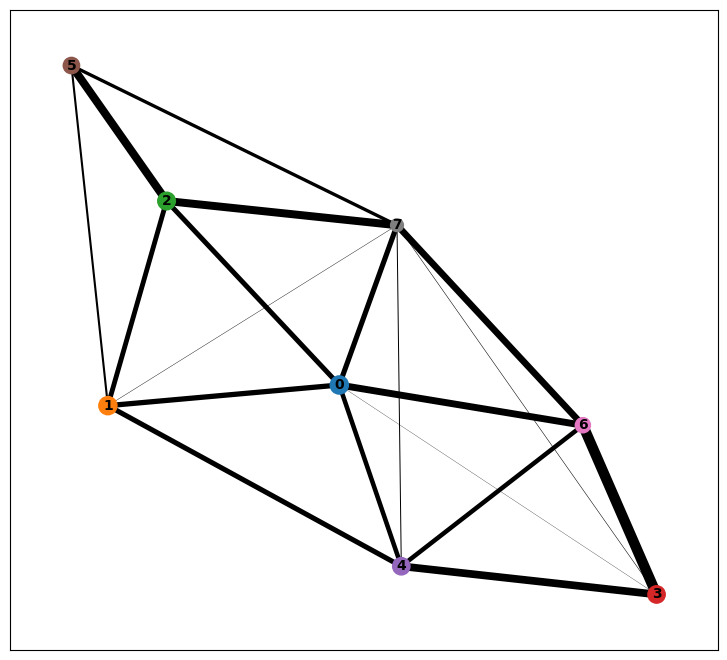

In [33]:
sc.pl.paga(merged, color='leiden')

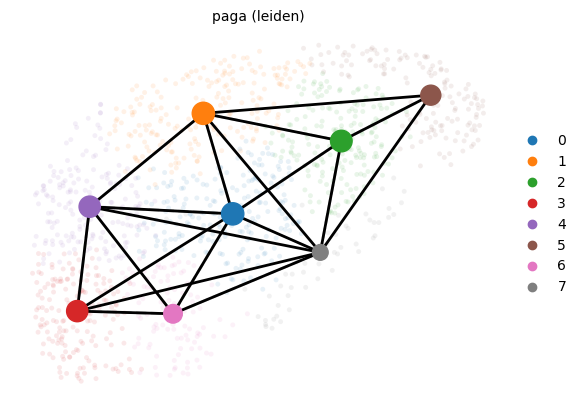

In [ ]:
## use this to identify the root node 
scv.pl.paga(merged, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


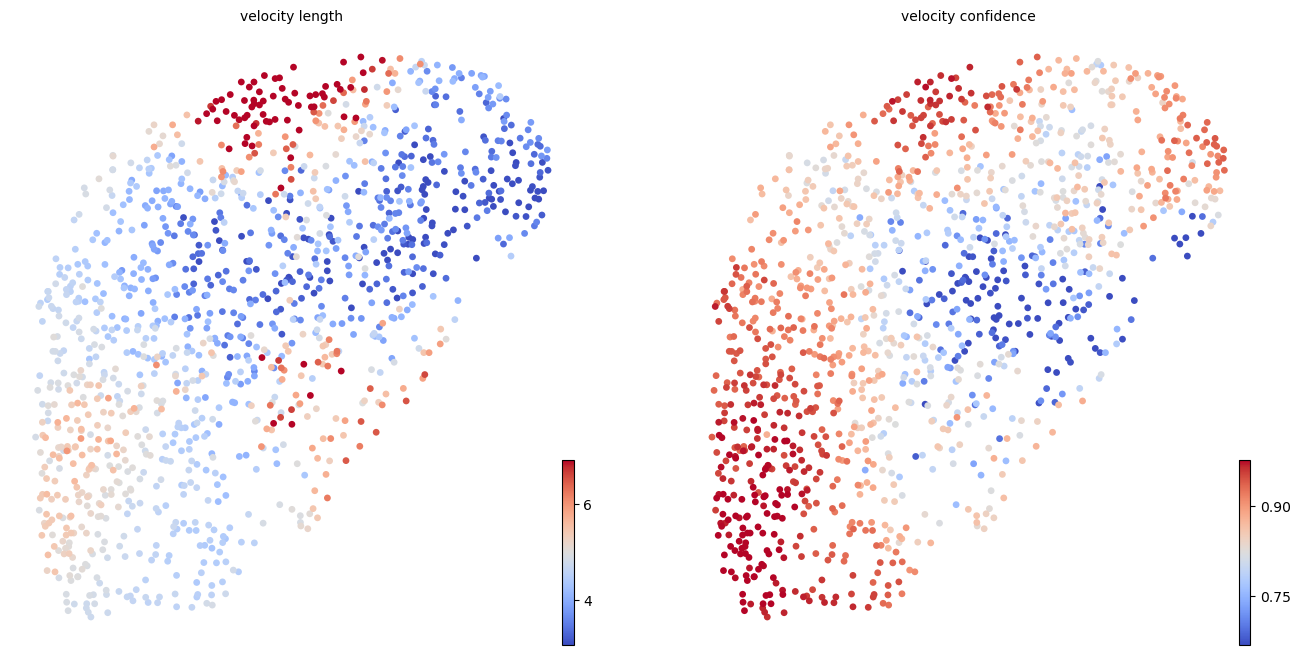

In [38]:
#Velocity length is the velocity data
#Velocity confidence is how confident the analysis is of the velocity length. IE want high confidence
scv.tl.velocity_confidence(merged)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(merged, c=keys, cmap='coolwarm', perc=[5, 95])

In [32]:
#Change "== '5'" to the appropriate root node in your graph
merged.uns['iroot'] = np.flatnonzero(merged.obs['leiden']  == '5')[0]
sc.tl.dpt(merged)
sc.tl.draw_graph(merged)

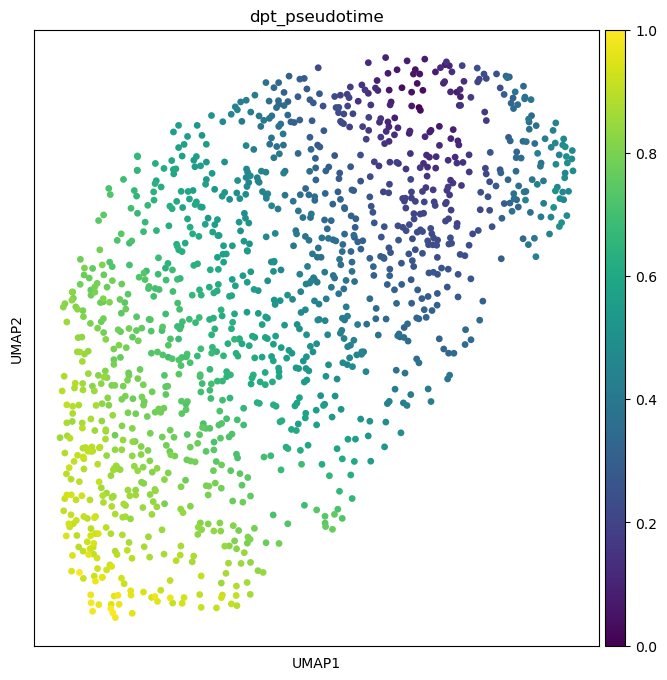

In [ ]:
#plot pseudotime on UMAP
sc.pl.umap(merged, color='dpt_pseudotime', legend_loc='on data')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


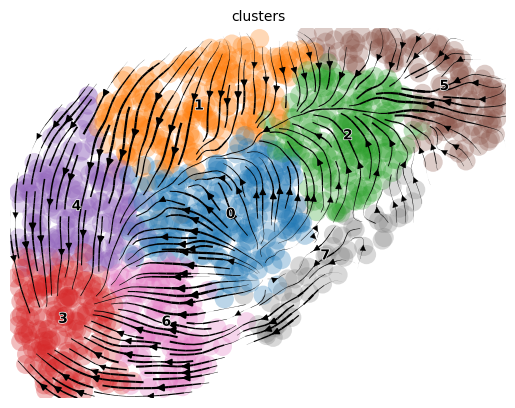

In [33]:
scv.pl.velocity_embedding_stream(merged, basis='umap')#, save ='M1727_umap_velocity_clusters_node5.svg')

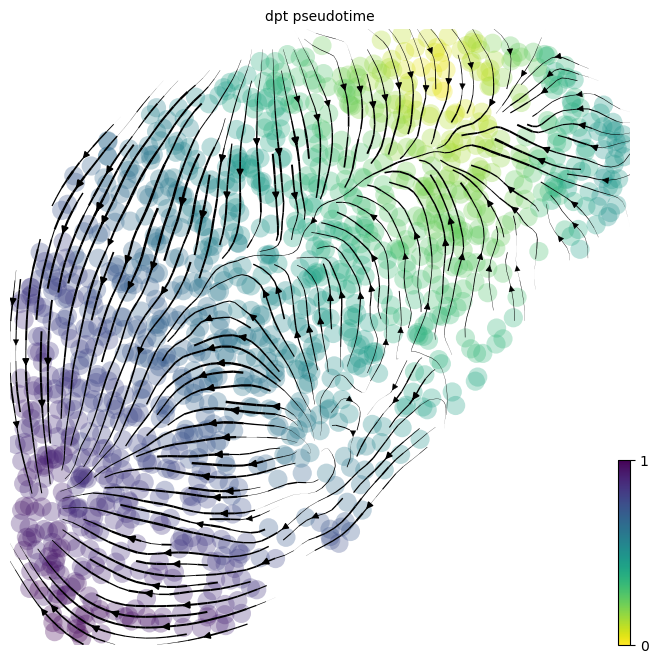

In [41]:
scv.pl.velocity_embedding_stream(merged, basis='umap', color='dpt_pseudotime')#save = 'M1727_umap_pseudotime_clusters_node5.svg')

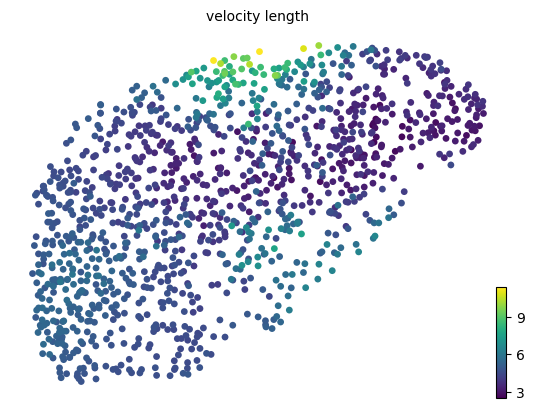

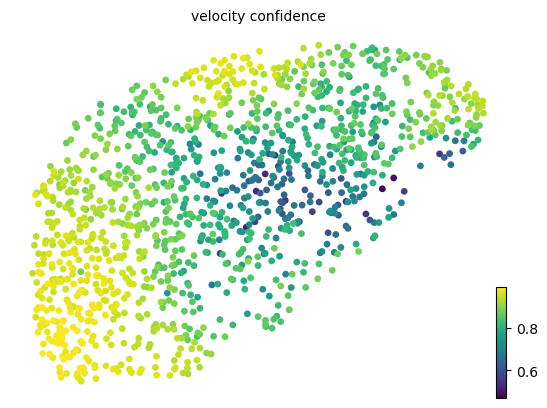

In [8]:
scv.pl.umap(merged, color = "velocity_length")
scv.pl.umap(merged, color= "velocity_confidence")

In [45]:
df = merged.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

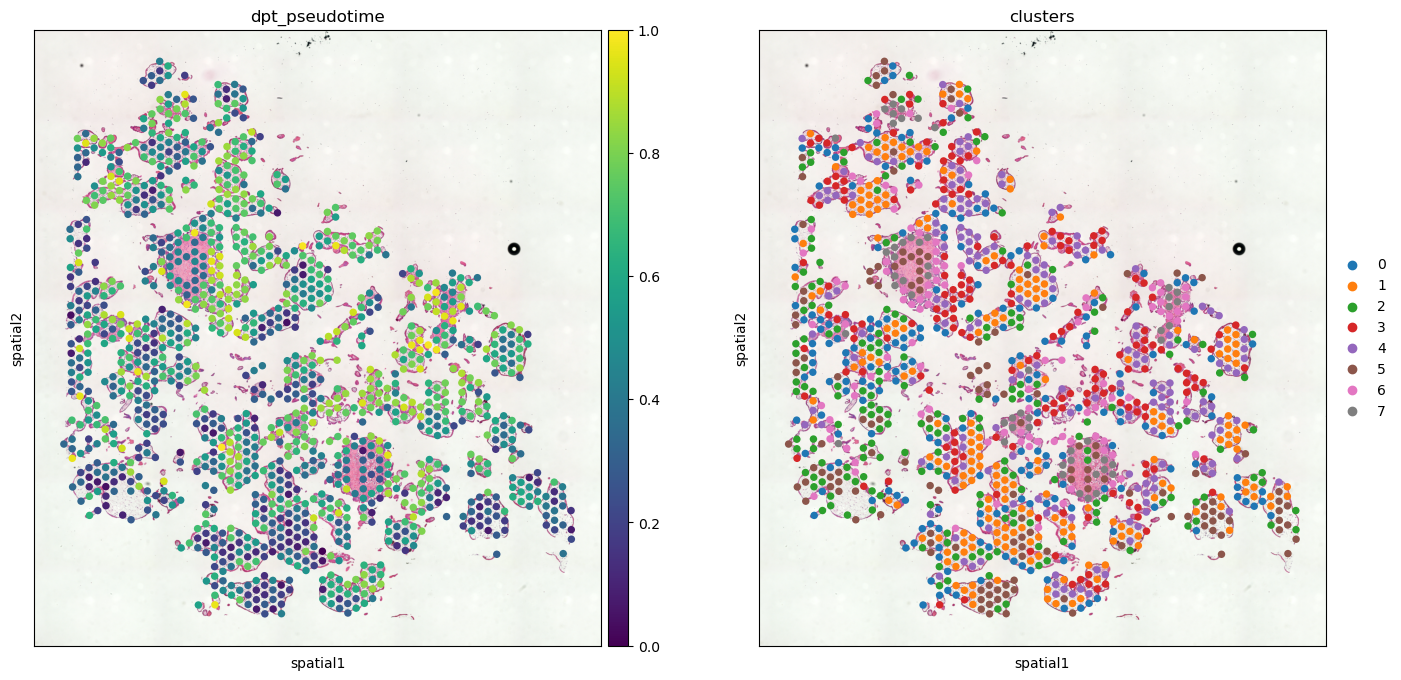

In [ ]:
# plot velocity pseudotime and clusters onto spatial data
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(merged, img_key="hires", color=["dpt_pseudotime", "clusters"], size=1.2 )

### Plotting velocity on spatial image

In [37]:
# turn into a pbsm X_ so that it an be plotted as basis= spatial. /1000 as numbers too large to plot 
merged.obsm["X_spatial"] = merged.obsm["spatial"]/1000

In [38]:
# if need to check what type it is
type(merged.obsm["spatial"])

numpy.ndarray

In [39]:
#plot wrong type compared to the X_umap so change to float32
merged.obsm["X_spatial"].astype("float32")

array([[ 5.447,  6.966],
       [13.009, 19.419],
       [12.725, 16.621],
       ...,
       [14.776, 16.6  ],
       [16.807, 14.517],
       [17.338, 16.28 ]], dtype=float32)

In [40]:
# plot wrong type so change columns to -1
merged.obsm["X_spatial"][:,1] *= -1

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


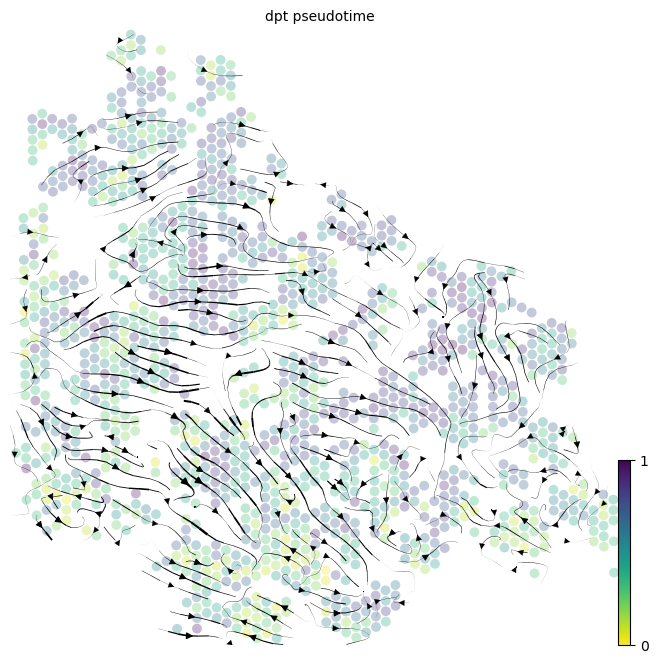

In [ ]:
# plot pseudotime and velocity streams
scv.pl.velocity_embedding_stream(merged, basis='spatial', color='dpt_pseudotime', size=200)#, save = 'M1727_spatial_velocity_pseudotime.svg')

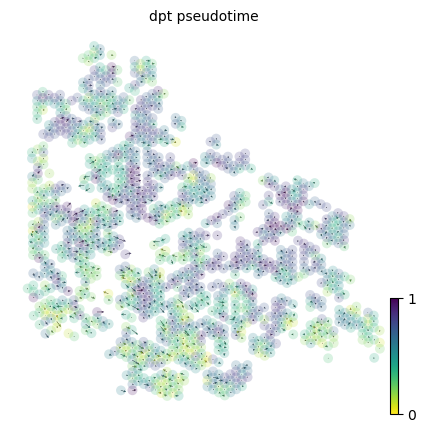

In [ ]:
#plot pseudtome and velocity stream per cell spot
scv.pl.velocity_embedding(merged, basis='spatial', color='dpt_pseudotime', size=200, figsize=(5,5))#, save = 'M1727_spatial_velocity_pseudotime_node5_5x5.svg')

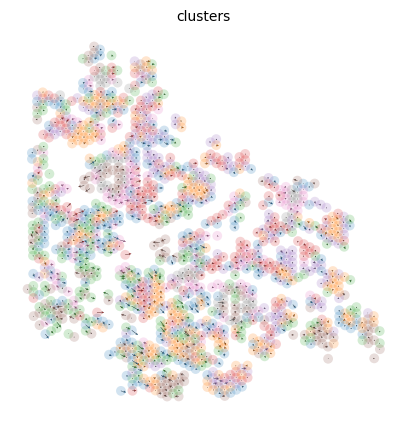

In [ ]:
# plot per cell spot velocity stream and leiden cluster
scv.pl.velocity_embedding(merged, basis='spatial', color='clusters', size=200, figsize=(5,5))#, save = 'M1727_spatial_velocity_length_node5.svg')

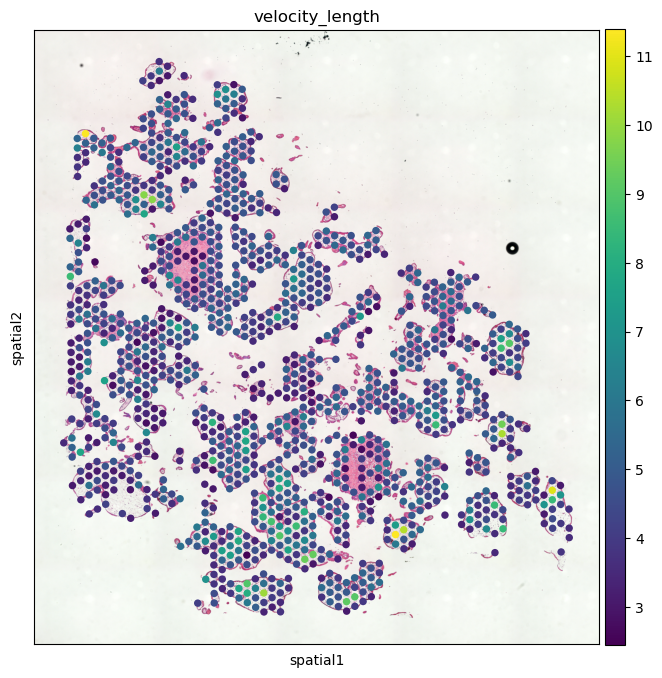

In [ ]:
# plot velocity length to spatial image
sc.pl.spatial(merged, img_key="hires", color="velocity_length", size=1.2)#, save = 'spatial_velocity_length.svg')

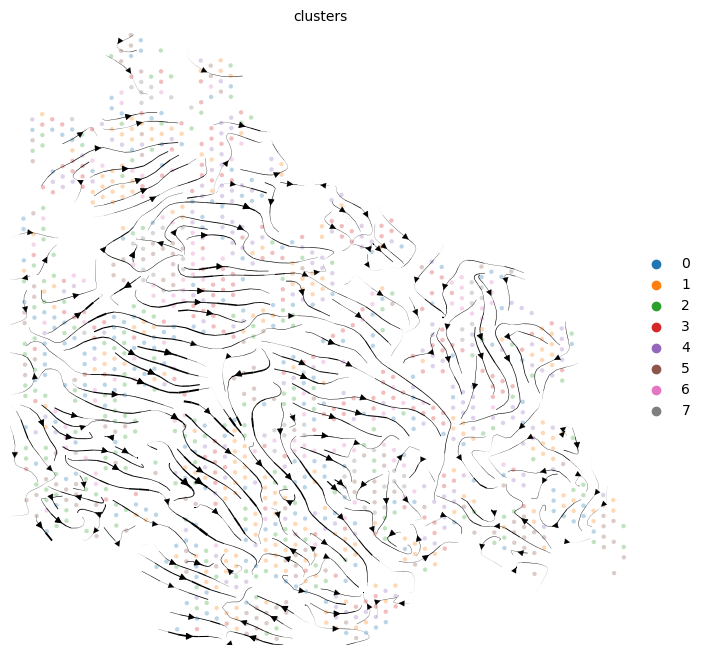

(None,)

In [44]:
scv.pl.velocity_embedding_stream(merged, color='clusters', basis='spatial', size=40,legend_loc='right'), #color='celltype_mapped_refined'
#plt.gca().invert_yaxis()

In [ ]:
# order groups for pseudotime violin plot below
my_order = merged.obs.groupby(by=["cell type"])["dpt_pseudotime"].median().sort_values().iloc[::-1].index
my_order

CategoricalIndex(['STB2', 'STB/EVT', 'FIBRO', 'STB1', 'FIBRO/HB', 'EVT',
                  'ENDO/FIBRO/HB', 'HB/FIBRO/CTB'],
                 categories=['STB1', 'FIBRO/HB', 'HB/FIBRO/CTB', 'STB2', 'FIBRO', 'ENDO/FIBRO/HB', 'STB/EVT', 'EVT'], ordered=False, dtype='category', name='cell type')

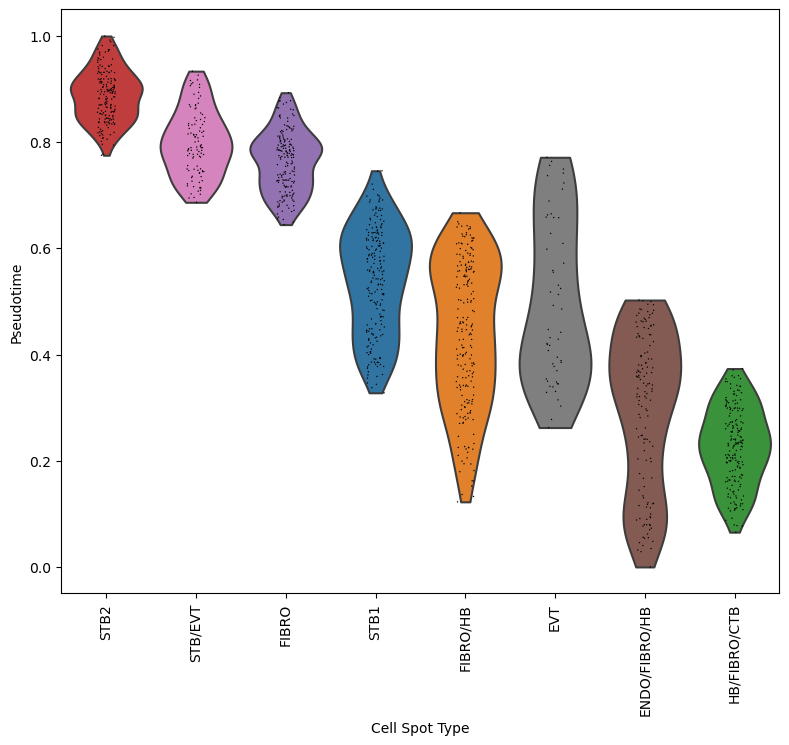

In [ ]:
# plot violin plot of pseudotime per names cluster - in decreasing order
sc.pl.violin(merged, 'dpt_pseudotime' , groupby="cell type", rotation= 90, order= my_order, xlabel= "Cell Spot Type", ylabel= "Pseudotime", save= "M1727_pseudotime_clusters_violin_nodes_sorted.svg")

### Neighbourhood enrichment and co-occurance

In [ ]:
# run routine neighbourhood enrichment
sq.gr.spatial_neighbors(merged, coord_type='grid')
sq.gr.nhood_enrichment(merged, cluster_key="clusters")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2729.05/s]


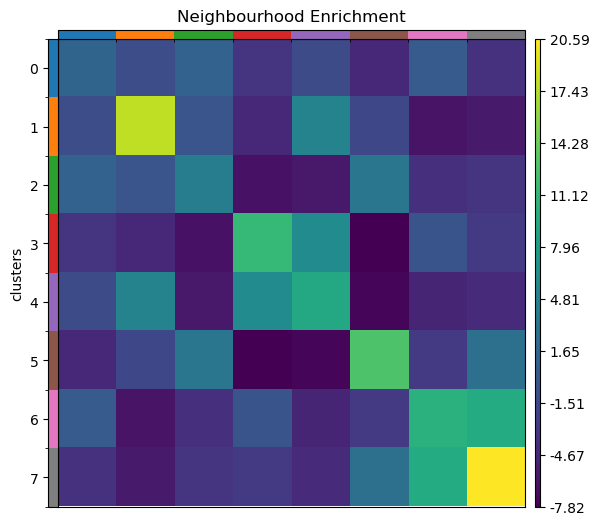

In [112]:
sq.pl.nhood_enrichment(merged, cluster_key="clusters", title= "Neighbourhood Enrichment") #save='M1727_neighbourhood_enrichment.svg')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13/s]


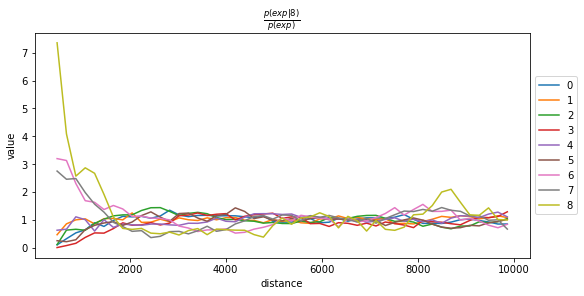

In [ ]:
# co-occurance graph for all clusters
sq.gr.co_occurrence(merged, cluster_key="clusters")
sq.pl.co_occurrence(
    merged,
    cluster_key="clusters",
    clusters ="8",
    figsize=(8, 4))#, save = 'cooccurance_8.svg'


In [44]:
# Identify important velocity genes 
scv.tl.rank_velocity_genes(merged, groupby='clusters', min_corr=.3)

df = scv.DataFrame(merged.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


0       1         2         3      4         5        6       7  \
0  ATPAF1   DDX17     RHPN2    TENT5C    TTR  ATP6V1G2     TBK1     TTR   
1    CUL7  FAM13A    ZNF687     KISS1    HBM      PLD3  FAM214A   MFAP5   
2    SYBU   GULP1    FAM83H    NELFCD  CELF2     PRPF6   COBLL1   CELF2   
3  IFT140    LGR4    TRIM29  TBC1D10C  SRPRB     PIAS2    POF1B    CDK6   
4   CCNT2    TET2  CDC42EP1    COMMD3  COX14     MEIS2    CD274  GPR155   

         8  
0     MESD  
1   SH3BP4  
2  GALNT11  
3  ATF7IP2  
4  IGF2BP2

### Velocities in cycling progenitors

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


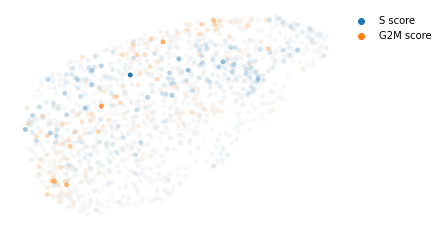

In [ ]:
# identify the difference cell-cycle states of all cell spots
scv.tl.score_genes_cell_cycle(merged)
scv.pl.umap(merged, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])


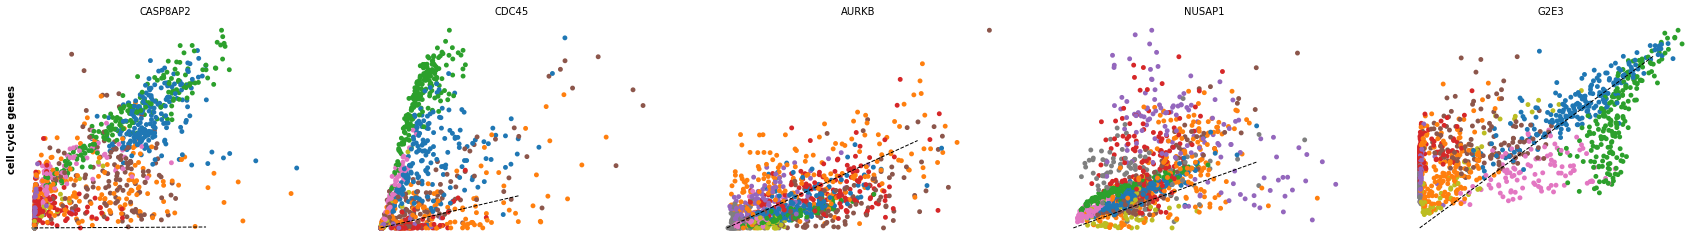

In [45]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(merged)
s_genes = scv.get_df(merged[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(merged[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(merged, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)
